# Gaussian Process Moment Matching for Squared Exponential Kernel

In the PILCO paper, it is nessecary to make predictions about the distribution of state $x_{t+1}$ from the distribution of state $x_t$. However, since the GP is nonlinear, even when $p(x_t)$ is a gaussian, the resulting distribution $p(f(x_t))$ is not guassian. This is shown in the figure below (taken from PILCO paper), and so the authors use an approximate method that replaces the non-gaussian output distribution with a gaussian that has the exact mean and covariance of the non-gaussian distribution.

<img src="moment_matching.png" alt="Drawing" style="width: 600px;"/>

### Problem Setup

Let's say we have a single input and we want to predict a single output. For instance, we want to predict the price of a stock tomorrow given its current value. This is a regression problem, and we can write $x_t$ for the current stock price and $x_{t+1}$ for the predicted price. In this example we have 6 datapoints on previous stock prices and we want to fit a curve to this using a guassian process. The model we're trying to learn then has the form

$$ x_{t+1} = \mathcal{GP}(x_t) + \epsilon$$

where $\epsilon\sim\mathcal{N}(0, \sigma^2_w)$ is a guassian random variable with zero mean and variance $\sigma^2_w$

In [359]:
import numpy as np
import tensorflow as tf
import gpflow as gpf
tf.logging.set_verbosity(tf.logging.FATAL)
plt.style.use("slides")
np.set_printoptions(suppress=True, linewidth=200, precision=6)

I'm not going to explain what a gaussian process is, but here is the model and the data we will be fitting. The important thing to note here is that we are using a Squared Exponential kernel, which has the hyperparameters lengthscale $\ell$ and variance $\sigma^2_f$

In [377]:
X = np.array([-0.8, -0.5, -0.15, -0.12, 0.4, 0.7]).reshape(-1, 1)
Y = np.array([0.3, 0.0, 0.25, 0.27, -0.12, 0.0]).reshape(-1, 1)
N, _ = X.shape
D = 1
U = 0
M = D + U

kernel = gpf.kernels.SquaredExponential(1, lengthscales=0.1)
kernels = [kernel]
m = gpf.models.GPR(X, Y, kernel)
opt = gpf.train.ScipyOptimizer()
opt.minimize(m)
m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.19197278433190046
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.03403615801234417
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000066306959922e-06


In [361]:
m.likelihood.variance.shape

()

we now define the input gaussian, called the "prior distribution", and written as $p(x_t)$. The PDF function evaluates the probability density function for a univariate gaussian at a bunch of x point so we can plot it.

In [362]:
mu_tilde_t = np.array([0.3])
siga_tilde_t = np.array([[0.08]])

def pdf(sample_x_points, mean, var):
    return 1/np.sqrt(2*np.pi*var) * np.exp(-0.5*(sample_x_points - mean)**2 * 1/(var))

## Computing The Mean

Note that the code written below should work for the general case where we have $D$ independant GPs, each with $M$ dimensions in our input (input in PILCO is $(x_t, u)$, but here we have no control input). So the index variables $a,b$ represent which GP/output dimension, but in this code we only have one dimension.  The training data are $X\in\mathbb{R}^{Nx(D+U)},Y\in\mathbb{R}^{NxD}$.

The input gaussian, calle the prior, is notated as $p(x_t) \sim \mathcal{N}(\mu_t, \Sigma_t)$

Here we go! Note that most of the choise of notation comes from [this paper](https://arxiv.org/abs/1706.06491), which is a follow up to PILCO.

$$
\begin{align}
  \text{first the mean} \\
 \mu_{{t+1}_a} &= \mathbb{E}[f_a(p(x_t))] \\
           &=  \beta_a^Tq_a\\
  \beta_a &= (K_a + \sigma^2_{\epsilon_a})^{-1}Y_a \\
  K_a &= k_a(X, X) \\
  k_a(X, X') &= \sigma^2_{f_a}\exp(-\tfrac{1}{2}(X-X')^T\Lambda_a^{-1}(X-X')) \\
  \Lambda_a &= \text{diag}\Big(\ell_{a,1}, \dots, \ell_{a,M}\Big) \\
  q_a &= [q_{a_1}, \dots, q_{a_N}]^T_a \\
  e_i &= exp(-\tfrac{1}{2}\nu^T_iT^{-1}\nu_i) \\
  q_{a_i} &= \frac{\sigma^2_{f_a}}{\big|\sqrt{(\Sigma_{t}\Lambda^{-1}_a + I)}\big|}e_i \\
  \nu_i &= x_i - \mu_t \\
  T_a &= \Sigma_t + \Lambda_a \\
  \text{and now for the covariance} \\
  \Sigma_{{t+1}_{a,b}} &= \\
\end{align}
$$

$\ell_{a,i}$ is the $i$th length scale of the $a$th GP

Here are the shapes of everything. In our example, $M=D+U=1$, $=D=1$, and $N=6$

|variable|shape|description|
|---|---|---|
|$X$|(N, M)|training data|
|$Y$|(N, D)|training labels}
|$\mu_{t}$|(M, 1)|mean of the prior|
|$\Sigma_{t}$|(M, M)|covariance of the prior|
|$\mu_{t+1}$|(D, 1)|mean of the posterior|
|$\Sigma_{t+1}$|(D, D)|covariance of the posterior|
|$\beta_a$|(N, 1)|
|$q_a$|(N)|
|$\sigma^2_{\epsilon_a}$|scalar|variance of the system noise for the ath GP|
|$\sigma^2_{f_a}$|scalar|variance of the GP likelihood for the ath GP|
|$\Lambda_a$|(M, M)|diagonal matrix of squared length scales|

In [363]:
# moment matching distribution
mu_tilde_t_plus_1 = np.ndarray((D, 1))
for a in range(D):
    k_a = kernels[a]
    K_a = k_a.compute_K_symm(X)
    sigma_w_sqrd_a = m.likelihood.variance.value
    sigma_f_sqrd_a = m.kern.variance.value
    lmbda_a = np.diag(np.square(np.array([m.kern.lengthscales.value])))
    inv_lambda_a = 1 / np.diag(np.square(np.array([m.kern.lengthscales.value])))
    # the times np.eye is from the PILCO code, I don't see it in the math...
    # GPFlow uses cholesky but this is simpler for testing purposes
    # this replaces doing the actual inverse 
    beta_a = np.linalg.lstsq(K_a + sigma_w_sqrd_a*np.eye(N), Y[:, a], rcond=1)[0]
    T_a = sigma_tilde_t + lmbda_a
    q_a = np.ndarray((N))
    for i in range(N):
        nu_i = X[i] - mu_tilde_t
        # this inverse is fine because T is a non-zero real scalar
        e_i = np.exp(-0.5 * nu_i.T@np.linalg.inv(T_a)@nu_i)
        # in the PILCO code they have another inv_lambda_a in this term?
        q_a_i = sigma_f_sqrd_a / np.sqrt(np.linalg.det(sigma_tilde_t@inv_lambda_a + np.eye(D))) * e_i
        q_a[i] = q_a_i
    mu_tilde_t_plus_1[a] = beta_a.T@q_a

sigma_tilde_t_plus_1 = np.ndarray((D, D))
mu_tilde_t_vec = np.ones((N, 1)) * mu_tilde_t

for a in range(D):
    k_a = kernels[a]
    K_a = k_a.compute_K_symm(X)
    K_a_x_mu_tilde = k_a.compute_K(X, mu_tilde_t_vec)
    sigma_w_sqrd_a = m.likelihood.variance.value
    sigma_f_sqrd_a = m.kern.variance.value
    # length scales are standard deviation not variance?
    inv_lambda_a = 1 / np.diag(np.square(np.array([m.kern.lengthscales.value])))
    beta_a = np.linalg.lstsq(K_a + sigma_w_sqrd_a*np.eye(N), Y[:, a], rcond=1)[0]
    iK = np.linalg.lstsq(K_a + sigma_w_sqrd_a*np.eye(N), np.eye(N), rcond=1)[0]
    for b in range(D):
        k_b = kernels[b]
        K_b = k_b.compute_K_symm(X)
        K_b_x_mu_tilde = k_b.compute_K(X, mu_tilde_t_vec)
        sigma_w_sqrd_b = m.likelihood.variance.value
        sigma_f_sqrd_b = m.kern.variance.value
        inv_lambda_b = 1 / np.diag(np.square(np.array([m.kern.lengthscales.value])))
        beta_b = np.linalg.lstsq(K_b + sigma_w_sqrd_b*np.eye(N), Y[:, b], rcond=1)[0]
        
        # missing negative sign?
        R = sigma_tilde_t @ (inv_lambda_a + inv_lambda_b) + np.eye(D)
        Q = np.ndarray((N, N))
        L = np.ndarray((N, N))
        for i in range(N):
            nu_i = X[i] - mu_tilde_t
            for j in range(N):
                nu_j = X[j] - mu_tilde_t
                z_i_j = inv_lambda_a@nu_i + inv_lambda_b@nu_j
                e_ab_ij = np.exp(0.5 * z_i_j.T@np.linalg.inv(R)@sigma_tilde_t@z_i_j)
                L[i,j] = e_ab_ij
                Q[i, j] = K_a_x_mu_tilde[i, 0] * K_b_x_mu_tilde[j, 0] / np.sqrt(np.linalg.det(R)) * e_ab_ij
        
        sigma_tilde_t_plus_1[a,b] = beta_b.T@Q@beta_b - mu_tilde_t_plus_1[a] * mu_tilde_t_plus_1[b]
        if a == b:
            sigma_tilde_t_plus_1[a,b] += sigma_f_sqrd_a - np.trace(iK @ Q)
print(mu_tilde_t_plus_1, sigma_tilde_t_plus_1)

[[0.020563]] [[0.023229]]


In [518]:
%%timeit
# first sample from p(x*), predict, then sample again from the predicted gaussian
x_tilde_t_samples = np.random.normal(mu_tilde_t[0], sigma_tilde_t[0,0]**0.5, 100).reshape(-1, 1)
f_x_tilde_t_samples_mean, f_x_tilde_t_samples_var = m.predict_y(x_tilde_t_samples)
y_samples = []
for mean_i, sigma_i in zip(f_x_tilde_t_samples_mean, f_x_tilde_t_samples_var):
    y_samples.extend(np.random.normal(mean_i, sigma_i**0.5, 100))
    
#imperical (sample) mean + var
sample_f_mean = np.mean(y_samples)
sample_f_var = np.var(y_samples)
# print(sample_f_mean, sample_f_var)

3.88 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [516]:
%%timeit
# Yet another approximate way is to only sample the input p(x*) and predict, no sampling on the other side
x_tilde_t_samples = np.random.normal(mu_tilde_t[0], sigma_tilde_t[0,0]**0.5, 10000).reshape(-1, 1)
f_x_tilde_t_samples_mean2, _ = m.predict_y(x_tilde_t_samples)

sample_f_mean2 = np.mean(f_x_tilde_t_samples_mean2)
sample_f_var2 = np.var(f_x_tilde_t_samples_mean2)
# print(sample_f_mean2, sample_f_var2)

2.07 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [511]:
## generate test points for prediction
n_test_points = 500
xx = np.linspace(-1, 1, n_test_points).reshape(n_test_points, 1)  # test points must be of shape (N, D)
p_x_tilde_t = pdf(xx, mu_tilde_t, sigma_tilde_t)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

p_x_tilde_t_plus_1_empirical = pdf(xx, sample_f_mean, sample_f_var)
p_x_tilde_t_plus_1_empirical2 = pdf(xx, sample_f_mean2, sample_f_var2)
p_x_tilde_t_plus_1 = pdf(xx, mu_tilde_t_plus_1, sigma_tilde_t_plus_1)

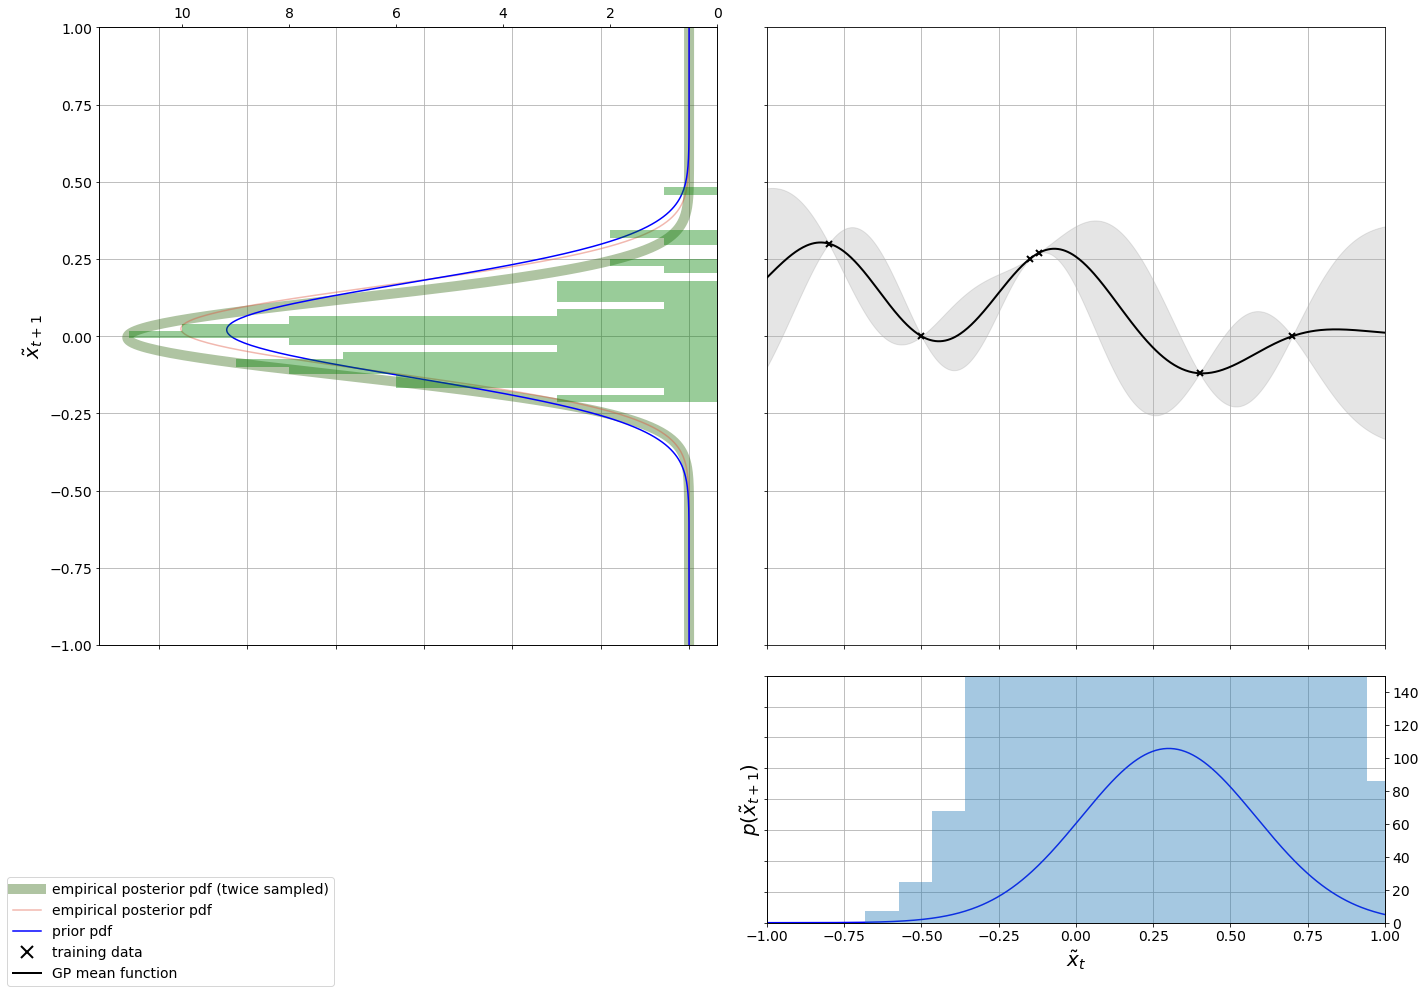

In [519]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(20,14), sharex='col', sharey='row', gridspec_kw={'height_ratios': [5, 2]})

axes[0,0].invert_xaxis()
axes[0,0].plot(p_x_tilde_t_plus_1_empirical, xx, color='#376C17', linewidth=10, alpha=0.4, label='empirical posterior pdf (twice sampled)')
axes[0,0].plot(p_x_tilde_t_plus_1_empirical2, xx, color='#DE4E37', alpha=0.4, label='empirical posterior pdf')
axes[0,0].plot(p_x_tilde_t_plus_1, xx, color='b')
hist_ax_00 = axes[0,0].twiny()
hist_ax_00.hist(y_samples, bins=30, orientation='horizontal', label='sampled posterior', color='green', alpha=0.4)
hist_ax_00.invert_xaxis()

axes[0,1].plot(X, Y, 'kx', mew=2, label='training data')
axes[0,1].plot(xx, mean, 'k', lw=2, label='GP mean function')
z_value = 1.96
axes[0,1].fill_between(xx[:,0],
                 mean[:,0] - z_value * np.sqrt(var[:,0]),
                 mean[:,0] + z_value * np.sqrt(var[:,0]),
                 color='grey', alpha=0.2)
axes[1,1].plot(xx, p_x_tilde_t, color='b', label='prior pdf')
hist_ax_11 = axes[1,1].twinx()
hist_ax_11.hist(x_tilde_t_samples, bins=20, label='sampled prior', alpha=0.4)

axes[0,1].set_xlim(-1, 1);
axes[0,1].set_ylim(-1, 1);
axes[0,0].set_ylim(-1, 1);
hist_ax_00.set_ylim(-1, 1);
axes[1,1].set_xlabel(r"$\tilde{x}_t$")
axes[1,1].set_ylabel(r"$p(\tilde{x}_{t+1})$");
axes[1,1].set_ylim(0, 2);
hist_ax_11.set_ylim(0, 150);
axes[0,0].set_ylabel(r"$\tilde{x}_{t+1}$");

axes[1,0].axis('off')

axes[0,0].grid()
axes[0,1].grid()
axes[1,1].grid()

fig.tight_layout()

handles_00, labels_00 = axes[0,0].get_legend_handles_labels()
handles_01, labels_01 = axes[0,1].get_legend_handles_labels()
handles_11, labels_11 = axes[1,1].get_legend_handles_labels()
handles = handles_00 + handles_11 + handles_01
labels = labels_00 + labels_11 + labels_01
fig.legend(handles, labels, loc='lower left');

### Mean prediction/inference

trying to make sure I understand GP math

In [508]:
x_star = np.array([[0.2]])
print(x_star, x_star.shape)
mean, sigma = m.predict_f(x_star)
print(mean)
print(sigma)

[[0.2]] (1, 1)
[[0.019088]]
[[0.016053]]


In [474]:
print(X, X.shape)
print(X)
print(N)

[[-0.8 ]
 [-0.5 ]
 [-0.15]
 [-0.12]
 [ 0.4 ]
 [ 0.7 ]] (6, 1)
[[-0.8 ]
 [-0.5 ]
 [-0.15]
 [-0.12]
 [ 0.4 ]
 [ 0.7 ]]
6


In [475]:
Knm = m.kern.compute_K(x_star, X)
Kmm = m.kern.compute_K_symm(X)
Knn = m.kern.compute_K_symm(x_star)
Kmn = Knm.T
Kmm_inv = np.linalg.lstsq(Kmm, np.eye(N), rcond=1)[0]
f = Y
f_star_mean = Knm@Kmm_inv@f
print(f_star_mean)
f_star_sigma = Knn - Knm@Kmm_inv@Kmn
print(f_star_sigma)

[[0.01918]]
[[0.016041]]


In [476]:
print(Knm)
print(Kmm)

[[0.       0.000044 0.006459 0.008484 0.019781 0.001145]]
[[0.034036 0.010038 0.00011  0.000064 0.       0.      ]
 [0.010038 0.034036 0.006459 0.004799 0.000001 0.      ]
 [0.00011  0.006459 0.034036 0.033623 0.000562 0.000002]
 [0.000064 0.004799 0.033623 0.034036 0.000868 0.000004]
 [0.       0.000001 0.000562 0.000868 0.034036 0.010038]
 [0.       0.       0.000002 0.000004 0.010038 0.034036]]


In [479]:
def my_k(X1, X2):
    variance = m.kern.variance.value
    lengthscales = m.kern.lengthscales.value
    r2 = np.square((X1-X2.T)/lengthscales)
    r2 = np.sum(np.square(X1/lengthscales), axis=-1, keepdims=True) + -2*(X1/lengthscales)@(X2/lengthscales).T + np.sum(np.square(X2/lengthscales), axis=-1, keepdims=True).T
    return variance * np.exp(-0.5 * r2)
    
my_Knm = my_k(X, x_star)
# my_Kmm = my_k(X, X)
my_Kmm_inv = np.linalg.lstsq(my_Kmm, np.eye(N), rcond=1)[0]
print(my_Knm)
# print(my_Kmm)

r2a  (6, 1)
[[27.134428]
 [13.29587 ]
 [ 3.323967]
 [ 2.778565]
 [ 1.085377]
 [ 6.783607]]
[[27.134428]
 [13.29587 ]
 [ 3.323967]
 [ 2.778565]
 [ 1.085377]
 [ 6.783607]]
r2b  (6, 1)
[[0.      ]
 [0.000044]
 [0.006459]
 [0.008484]
 [0.019781]
 [0.001145]]


In [480]:
variance = m.kern.variance.value
lengthscales = m.kern.lengthscales.value
lambda_inv = np.diag(1/np.atleast_2d(lengthscales))
T = np.square((X-x_star.T)/lengthscales).T
-my_Kmm_inv@Y*np.exp(-0.5*T)#@(X-x_star.T).T@lambda_inv

array([[ -0.000013,  -0.012698,  -1.858283,  -2.440868,  -5.691353,  -0.329504],
       [  0.000004,   0.004279,   0.626144,   0.822445,   1.917688,   0.111026],
       [  0.00002 ,   0.020161,   2.95042 ,   3.875399,   9.036237,   0.523158],
       [ -0.000031,  -0.030922,  -4.525251,  -5.943951, -13.859463,  -0.802401],
       [  0.000005,   0.005506,   0.805768,   1.058382,   2.467822,   0.142876],
       [ -0.000002,  -0.001622,  -0.237307,  -0.311704,  -0.726798,  -0.042078]])

In [445]:
Y.shape

(6, 1)

In [446]:
T.shape

(6, 2)

In [ ]:
np.square(X/lengthscales)-x_star

In [456]:
np.sum([[1,2],[4,5]], axis=1, keepdims=True)

array([[3],
       [9]])